# Genshin Impact Wishing and Pity System Analysis

This notebook aims to analyze and draw statistics from Genshin Impact's Wishing System through **simulation** in several ways:
1. Determine the average amount of wishes it takes to obtain a 5-star character (standard <u>or</u> limited) on a limited 5-star character's banner
2. Determine the average amount of wishes it takes to obtain a **limited** 5-star character on a limited 5-star character's banner
3. Determine how many wishes it takes, on average, to obtain a C6 limited 5-star character on a limited 5-star character's banner
4. Determine the odds of getting 2 or more limited 5-stars in one ten pull on a limited 5-star character's banner

In [44]:
# Imports
import pandas as pd
import numpy as np 
import matplotlib as plt

## Simulation Prep
We must first build a system to simulate Genshin Impact's Wishing System, which will include functions to do a single or ten pull, have a pity system, and a 50/50 system, just like in Genshin Impact's Wishing System.

* ```pity```: The amount of wishes made so far for the next 5-star
* ```four_star_pity```: The amount of wishes made so far for the next 4-star
* ```on_fifty_fifty```: ```True``` if we are currently on the 50/50, ```False``` otherwise
* ```five_star_chance```: The *percentage* chance of getting a 5-star character
* ```four_star_chance```: The *percentage* chance of getting a 4-star character or item

We can break down all the possible items you can obtain in one wish into 4 categories:

* ```"3-star"```
* ```"4-star"```
* ```"Standard 5-star"```
* ```"Limited 5-star"```

In [4]:
# Wish Variables
pity = 0 
four_star_pity = 0
on_fifty_fifty = True
FIVE_STAR_CHANCE = 0.6
FOUR_STAR_CHANCE = 5.1

# Wishing Functions
# Function to wish once (pity IS included in wish calculation, e.g. 90 pity means 90th wish, 89 pity means 89th wish, etc.)
def wish(pity, four_star_pity, on_fifty_fifty, five_star_chance, four_star_chance):
    # Define obtainable characters / items
    obtainables = ["3-star", "4-star", "Standard 5-star", "Limited 5-star"]

    # Calculate probabilities for four and five stars (three star prob will be calculated later using four and five star probs)
    five_star_prob = five_star_chance / 100
    four_star_prob = four_star_chance / 100

    # Adjust probabilities according to pity
    if pity >= 74:
        five_star_prob = (five_star_chance + five_star_chance * 10 * abs(73 - pity)) / 100
    
    if four_star_pity >= 9:
        four_star_prob = (four_star_chance + four_star_chance * 10 * abs(8 - four_star_pity)) / 100

    # Check and adjust probabilities to ensure that they sum to 1
    if five_star_prob + four_star_prob > 1:
        if five_star_prob > 1:
            five_star_prob = 1
            four_star_prob = 0
        elif five_star_prob < 1:
            four_star_prob -= five_star_prob + four_star_prob - 1

    # Edge cases
    if four_star_pity == 10 and pity < 90:
        four_star_prob = 1
        five_star_prob = 0

    # Calculate three star prob
    three_star_prob = 1 - five_star_prob - four_star_prob

    if three_star_prob < 0:
        three_star_prob = 0

    # Perform the wish (Randomly choose what rarity of item / character this wish will grant)
    if on_fifty_fifty:
        probs = [three_star_prob, four_star_prob, five_star_prob / 2, five_star_prob / 2]
    else:
        probs = [three_star_prob, four_star_prob, 0, five_star_prob]

    #print(probs)
    return np.random.choice(obtainables, 1, p = probs)[0]

print(wish(1, 1, True, FIVE_STAR_CHANCE, FOUR_STAR_CHANCE))

4-star


In [5]:
# Test the function a few times to see that it works properly
print(wish(90, 10, False, FIVE_STAR_CHANCE, FOUR_STAR_CHANCE))

Limited 5-star


Now that we can simulate one wish, we will put together the whole wishing system, with a system to keep track of pity and a 10 wish function. Let's first create a function to simulate 10 wishes.

In [6]:
def ten_wish(pity, four_star_pity, on_fifty_fifty):
    obtained = np.array([])

    for i in range(10):
        pity += 1
        four_star_pity += 1

        result = wish(pity, four_star_pity, on_fifty_fifty, FIVE_STAR_CHANCE, FOUR_STAR_CHANCE)
        obtained = np.append(obtained, result)

        if "5-star" in result:
            pity = 0
            if result == "Standard 5-star":
                on_fifty_fifty = False
            else:
                on_fifty_fifty = True
        else:
            if result == "4-star":
                four_star_pity = 0

    updated_status = np.array([pity, four_star_pity, on_fifty_fifty])
    return [obtained, updated_status]

print(ten_wish(75, 0, False))

[array(['Limited 5-star', '3-star', '4-star', '3-star', '3-star', '3-star',
       '3-star', '3-star', '3-star', '3-star'], dtype='<U32'), array([9, 7, 1])]


Now that we have a function to simulate 10 wishes, our gacha system is complete. Let's now do some analysis.

### Question 1. How many wishes does it take, on average, to obtain a 5-star character (standard or limited) on a 5-star character's banner, starting from 0 pity?

In [7]:
# System variables
repetitions = 10000 # amount of samples
wishes_to_obtain_five_star = np.array([])
pity = 0
four_star_pity = 0
on_fifty_fifty = True

# For x amount of repetitions, create a new system (0 pity, 0 four star pity, on 50/50) and keep wishing until you get a 5-star. Record the amount of pity and move on
for i in range(repetitions):
    pity = 0
    four_star_pity = 0
    on_fifty_fifty = True
    obtained_five_star = False

    while not obtained_five_star:
        pity += 1
        four_star_pity += 1

        result = wish(pity, four_star_pity, on_fifty_fifty, FIVE_STAR_CHANCE, FOUR_STAR_CHANCE)

        if "5-star" in result:
            wishes_to_obtain_five_star = np.append(wishes_to_obtain_five_star, pity)
            obtained_five_star = True
        elif result == "4-star":
            four_star_pity = 0

avg_amount_wishes_to_obtain_five_star = wishes_to_obtain_five_star.mean()
print("The average amount of wishes it takes to get a 5-star character from 0 pity is: " + str(avg_amount_wishes_to_obtain_five_star))

The average amount of wishes it takes to get a 5-star character from 0 pity is: 62.486


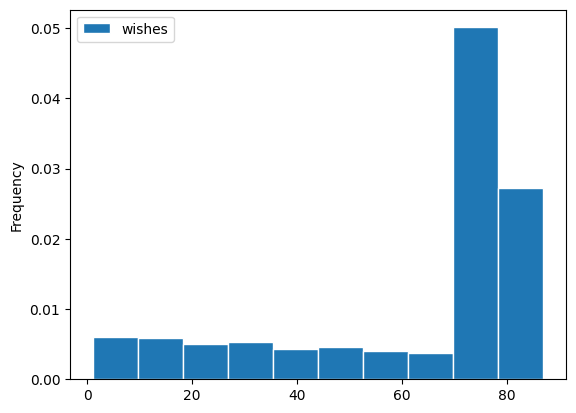

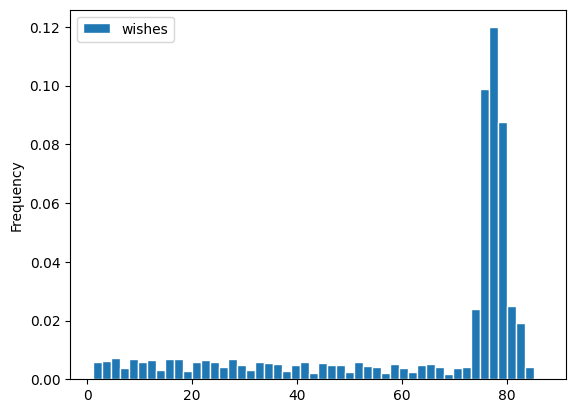

In [8]:
pd.DataFrame().assign(wishes = wishes_to_obtain_five_star).plot(kind = "hist", density = True, ec = "w");
pd.DataFrame().assign(wishes = wishes_to_obtain_five_star).plot(kind = "hist", density = True, ec = "w", bins = 50);


### Interesting!
It looks like the average amount of wishes to obtain a 5-star character, starting from 0 pity, is around...
<details>
<summary>click to see!</summary>
62
</details> 

wishes.

### Question 2. How many wishes does it take, on average, to obtain a **limited** 5-star character on a limited 5-star character's banner, starting from 0 pity?

In [9]:
# System variables
repetitions = 10000 # amount of samples
wishes_to_obtain_limited_five_star = np.array([])
fifty_fifties = np.array([])
pity = 0
four_star_pity = 0
on_fifty_fifty = True

# For x amount of repetitions, create a new system (0 pity, 0 four star pity, on 50/50) and keep wishing until you get a limited 5-star. Record the amount of pity and move on
for i in range(repetitions):
    total_wishes = 0
    pity = 0
    four_star_pity = 0
    on_fifty_fifty = True
    obtained_limited_five_star = False
    won_fifty_fifty = True

    while not obtained_limited_five_star:
        total_wishes += 1
        pity += 1
        four_star_pity += 1

        result = wish(pity, four_star_pity, on_fifty_fifty, FIVE_STAR_CHANCE, FOUR_STAR_CHANCE)

        if result == "Limited 5-star":
            wishes_to_obtain_limited_five_star = np.append(wishes_to_obtain_limited_five_star, total_wishes)
            obtained_limited_five_star = True
            fifty_fifties = np.append(fifty_fifties, won_fifty_fifty)
        elif result == "Standard 5-star":
            on_fifty_fifty = False
            pity = 0
            won_fifty_fifty = False
        elif result == "4-star":
            four_star_pity = 0

avg_amount_wishes_to_obtain_limited_five_star = wishes_to_obtain_limited_five_star.mean()
print("The average amount of wishes it takes to get a limited 5-star character from 0 pity is: " + str(avg_amount_wishes_to_obtain_limited_five_star))

The average amount of wishes it takes to get a limited 5-star character from 0 pity is: 94.1178


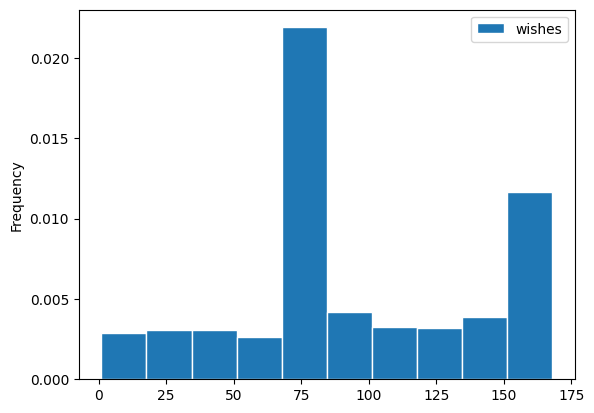

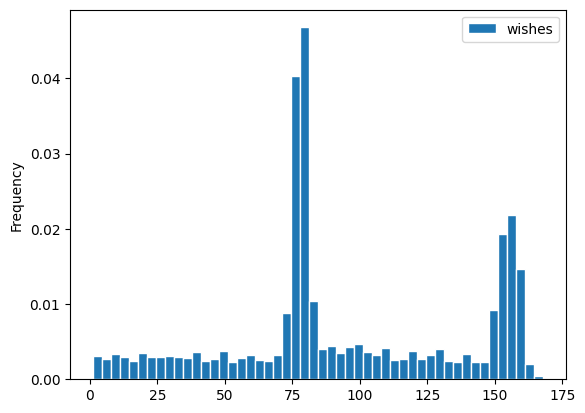

In [10]:
pd.DataFrame().assign(wishes = wishes_to_obtain_limited_five_star).plot(kind = "hist", density = True, ec = "w");
pd.DataFrame().assign(wishes = wishes_to_obtain_limited_five_star).plot(kind = "hist", density = True, ec = "w", bins = 50);

### Woah!
According to the results of our simulation, the average amount of wishes to obtain a limited 5-star character, starting from 0 pity, is around...
<details>
<summary>click to see!</summary>
94
</details>

wishes.

### Also...
According to the bar graphs above, it seems like we got most of our limited 5-star characters around 75 pity, with a spike in around the 155 pity range. If we got more limited 5-star characters in the 75 pity range, then that must mean that we *won* more 50/50s than lost 50/50s... is that really the case? Let's find out!

### Question 2.5. Did we really win more 50/50s than lose 50/50s when wishing for a limited 5-star character?

In [11]:
percentage_won = np.count_nonzero(fifty_fifties) / 10000 * 100
percentage_lost = 100 - percentage_won
print("The simulation shows we won " + str(percentage_won) + "% of 50/50s.")
print("The simulation shows we lost " + str(percentage_lost) + "% of 50/50s.")

The simulation shows we won 49.96% of 50/50s.
The simulation shows we lost 50.04% of 50/50s.


So, if the amount of 50/50s we win and lose is about the same, why does it look like we get more limited 5-star characters at around 75 pity, the winning 50/50 mark? Well, it turns out, if you look to the right of 75, that flat plateau is slightly taller than the plateau to the left of 75, which could explain the difference.

### Question 3. How many wishes does it take, on average, to obtain a C6 limited 5-star character on a limited 5-star character's banner, starting from 0 pity?

In [12]:
# System variables
repetitions = 10000 # amount of samples
wishes_to_obtain_C6_limited_five_star = np.array([])
pity = 0
four_star_pity = 0
on_fifty_fifty = True

# For x amount of repetitions, create a new system (0 pity, 0 four star pity, on 50/50) and keep wishing until you get a limited 5-star. Record the amount of pity and move on
for i in range(repetitions):
    total_wishes = 0
    pity = 0
    four_star_pity = 0
    on_fifty_fifty = True
    copies = 0

    while copies < 7:
        total_wishes += 1
        pity += 1
        four_star_pity += 1

        result = wish(pity, four_star_pity, on_fifty_fifty, FIVE_STAR_CHANCE, FOUR_STAR_CHANCE)

        if result == "Limited 5-star":
            copies += 1
            on_fifty_fifty = True
            pity = 0
        elif result == "Standard 5-star":
            on_fifty_fifty = False
            pity = 0
        elif result == "4-star":
            four_star_pity = 0

        if copies >= 7:
            wishes_to_obtain_C6_limited_five_star = np.append(wishes_to_obtain_C6_limited_five_star, total_wishes)

avg_amount_wishes_to_obtain_C6_limited_five_star = wishes_to_obtain_C6_limited_five_star.mean()
print("The average amount of wishes it takes to get a C6 limited 5-star character from 0 pity is: " + str(avg_amount_wishes_to_obtain_C6_limited_five_star))

The average amount of wishes it takes to get a C6 limited 5-star character from 0 pity is: 659.7412


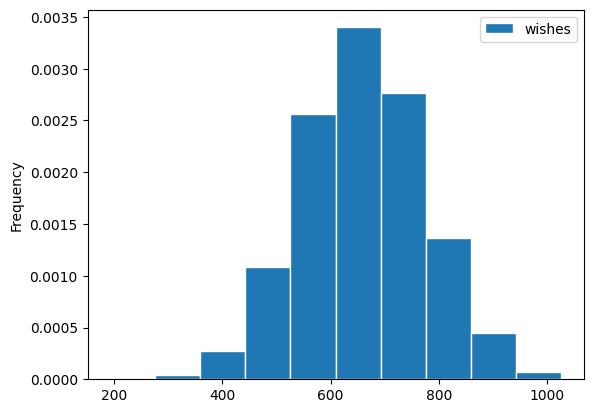

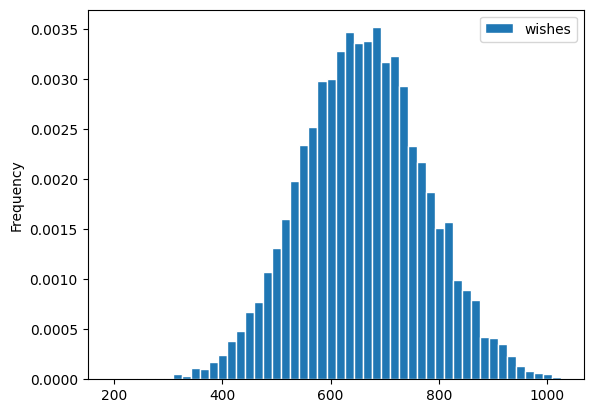

In [13]:
pd.DataFrame().assign(wishes = wishes_to_obtain_C6_limited_five_star).plot(kind = "hist", density = True, ec = "w");
pd.DataFrame().assign(wishes = wishes_to_obtain_C6_limited_five_star).plot(kind = "hist", density = True, ec = "w", bins = 50);

### So...
The average amount of wishes it takes to obtain a C6 limited 5-star character, starting from 0 pity, is around...
<details>
<summary>click to see!</summary>
660
</details>

wishes.

That's pretty expensive! If we converted that amount of wishes into primogems, it would equate to 105,600 primogems! Now that's a *lot* of primogems!

Let's do a little more analysis. What if we basically wanted to guarantee a C6 limited 5-star character? How many wishes would that take? We could just do 180 wishes * 7 copies to get 1260 wishes, which would absolutely guarantee a C6 limited 5-star character, but that is an extreme edge case. Let's find a more reasonable amount using standard deviation.

In [14]:
C6_std = np.std(wishes_to_obtain_C6_limited_five_star)
certainty_97_5 = avg_amount_wishes_to_obtain_C6_limited_five_star + C6_std * 2 # 2 stds is 95%, but left of average is included implicitly since we pass that mark
print("If we wanted to guarantee a C6 limited five-star character with 97.5% certainty, then it would take " + str(certainty_97_5) + " wishes.")

If we wanted to guarantee a C6 limited five-star character with 97.5% certainty, then it would take 886.878420398243 wishes.


So, if we *basically* wanted to guarantee a C6 limited 5-star character, it would take approximately 887 wishes.

### Question 4. What are the odds of getting 2 or more limited 5-star characters in one ten pull on a limited 5-star character's banner?
Since the pity system may affect the answer to this question, we will run two separate tests: doing ten pulls from 0 pity, and doing ten pulls from 75 pity. For both of these tests, we will be starting on the 50/50.

### Doing ten pulls from 0 pity

In [15]:
repetitions = 10000
two_limited_five_stars = np.array([])

for i in range(repetitions):
    one_ten_wish = ten_wish(0, 0, False)[0]

    if np.count_nonzero(one_ten_wish == "Limited 5-star") >= 2:
        two_limited_five_stars = np.append(two_limited_five_stars, True)
    else:
        two_limited_five_stars = np.append(two_limited_five_stars, False)

two_limited_five_stars_count = np.count_nonzero(two_limited_five_stars)
two_limited_five_stars_prop = two_limited_five_stars_count / repetitions
print("Staring from 0 pity:")
print("Out of " + str(repetitions) + " ten pulls, " + str(two_limited_five_stars_count) + " of the ten pulls had 2 or more limited 5-star characters.")
print("In percentage, this equates to a " + str(two_limited_five_stars_prop * 100) + "% chance of getting 2 or more limited 5-star characters in one ten pull.")

Staring from 0 pity:
Out of 10000 ten pulls, 10 of the ten pulls had 2 or more limited 5-star characters.
In percentage, this equates to a 0.1% chance of getting 2 or more limited 5-star characters in one ten pull.


### Doing ten pulls from 75 pity

In [16]:
repetitions = 10000
two_limited_five_stars = np.array([])

for i in range(repetitions):
    one_ten_wish = ten_wish(75, 0, False)[0]

    if np.count_nonzero(one_ten_wish == "Limited 5-star") >= 2:
        two_limited_five_stars = np.append(two_limited_five_stars, True)
    else:
        two_limited_five_stars = np.append(two_limited_five_stars, False)

two_limited_five_stars_count = np.count_nonzero(two_limited_five_stars)
two_limited_five_stars_prop = two_limited_five_stars_count / repetitions
print("Starting from 75 pity:")
print("Out of " + str(repetitions) + " ten pulls, " + str(two_limited_five_stars_count) + " of the ten pulls had 2 or more limited 5-star characters.")
print("In percentage, this equates to a " + str(two_limited_five_stars_prop * 100) + "% chance of getting 2 or more limited 5-star characters in one ten pull.")

Starting from 75 pity:
Out of 10000 ten pulls, 190 of the ten pulls had 2 or more limited 5-star characters.
In percentage, this equates to a 1.9% chance of getting 2 or more limited 5-star characters in one ten pull.


### What about the chances of getting two or more 5-star characters in general (standard or limited) in a single ten pull?
Again, we will first start the simulation with 0 pity, then 75 pity.

In [17]:
repetitions = 10000
two_five_stars = np.array([])

for i in range(repetitions):
    one_ten_wish = ten_wish(0, 0, False)[0]

    if np.count_nonzero(one_ten_wish == "Limited 5-star") + np.count_nonzero(one_ten_wish == "Standard 5-star") >= 2:
        two_five_stars = np.append(two_five_stars, True)
    else:
        two_five_stars = np.append(two_five_stars, False)

two_five_stars_count = np.count_nonzero(two_five_stars)
two_five_stars_prop = two_five_stars_count / repetitions
print("Starting from 0 pity:")
print("Out of " + str(repetitions) + " ten pulls, " + str(two_five_stars_count) + " of the ten pulls had 2 or more 5-star characters.")
print("In percentage, this equates to a " + str(two_five_stars_prop * 100) + "% chance of getting 2 or more 5-star characters in one ten pull.")

Starting from 0 pity:
Out of 10000 ten pulls, 14 of the ten pulls had 2 or more 5-star characters.
In percentage, this equates to a 0.13999999999999999% chance of getting 2 or more 5-star characters in one ten pull.


In [18]:
repetitions = 10000
two_five_stars = np.array([])

for i in range(repetitions):
    one_ten_wish = ten_wish(75, 0, False)[0]

    if np.count_nonzero(one_ten_wish == "Limited 5-star") + np.count_nonzero(one_ten_wish == "Standard 5-star") >= 2:
        two_five_stars = np.append(two_five_stars, True)
    else:
        two_five_stars = np.append(two_five_stars, False)

two_five_stars_count = np.count_nonzero(two_five_stars)
two_five_stars_prop = two_five_stars_count / repetitions
print("Starting from 75 pity:")
print("Out of " + str(repetitions) + " ten pulls, " + str(two_five_stars_count) + " of the ten pulls had 2 or more 5-star characters.")
print("In percentage, this equates to a " + str(two_five_stars_prop * 100) + "% chance of getting 2 or more 5-star characters in one ten pull.")

Starting from 75 pity:
Out of 10000 ten pulls, 366 of the ten pulls had 2 or more 5-star characters.
In percentage, this equates to a 3.66% chance of getting 2 or more 5-star characters in one ten pull.


### How much do the results from our simulation vary?
To find out, we will do, for 100 times, 1000 ten pulls, and for each of those 1000 ten pulls, we will count how many of them had 2 or more 5-star characters. We will then plot the data. We will start from 75 pity so that the counts are higher and easier to visualize (starting from 0 pity with result in counts mostly only from 1 to 6, which are low numbers that are hard to visualize).

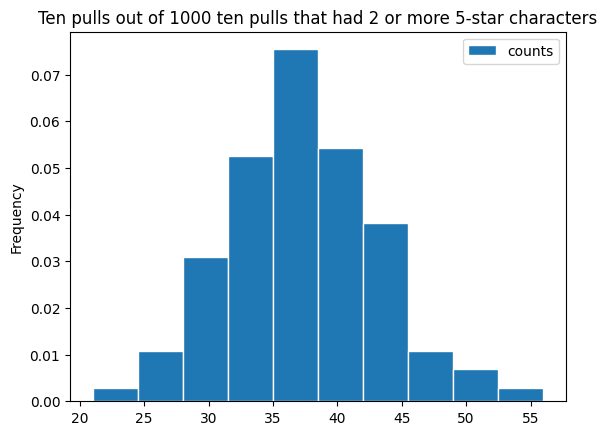

In [19]:
repetitions = 500
counts_out_of_thousand = np.array([])

for i in range(repetitions):
    two_five_stars = np.array([])

    for j in range(1000):
        one_ten_wish = ten_wish(75, 0, False)[0]

        if np.count_nonzero(one_ten_wish == "Limited 5-star") + np.count_nonzero(one_ten_wish == "Standard 5-star") >= 2:
            two_five_stars = np.append(two_five_stars, True)
        else:
            two_five_stars = np.append(two_five_stars, False)

    two_five_stars_count = np.count_nonzero(two_five_stars)
    counts_out_of_thousand = np.append(counts_out_of_thousand, two_five_stars_count)
    
pd.DataFrame().assign(counts = counts_out_of_thousand).plot(kind = "hist", density = True, ec = "w", title = "Ten pulls out of 1000 ten pulls that had 2 or more 5-star characters");

The histogram above shows that if you do 1,000 ten pulls many, many times, the most common amount of those ten pulls out of 1,000 ten pulls that will have 2 or more 5-star characters, is around 35 ten pulls. That translates into 3.5% being the most common percentage of ten pulls that will have 2 or more 5-star characters.

So, for example, if you did 100 ten pulls, and each of those 100 ten pulls started from 75 pity, roughly 3 out of those 100 ten pulls will have 2 or more 5-star characters, according to the results of our simulation.

### In Conclusion...

We can conclude that the odds of getting 2 or more 5-star characters in one ten pull, depending on your pity, is anywhere from 0.10% to 4%, give or take a little.

The odds of getting 2 or more *limited* 5-star characters in one ten pull, depending on your pity, is anywhere from 0.08% to 2.05%, give or take a little.